# Plot result
### the structure of data
- each row of data is correspond to a **steady distribution of money $m$ to $N (N=1000)$ agents**, I condunct $n (n=1000)$ times simulation

|          | $x_{1}$ | $x_{2}$ | $x_{3}$ | ... | $x_{N}$ |
| -------- | ------- | ------- | ------- | --- | ------- |
| $1$      |         |         |         |     |         |
| $2$      |         |         |         |     |         |
| $\vdots$ |         |         |         |     |         |
| $n$      |         |         |         |     |         |

### using Packages
- `CSV`: used to read the simulation result which is stored in `.csv` file.
- `DataFrame`: read the `.csv` file as `::DataFrame` type, which is similar to `pandas` in `python`.
- `CairoMakie`: used to draw charts.
- `StatsBase`: consist of basic function about statistics such as `mean`, `std`.

In [1]:
using CSV, DataFrames, CairoMakie, StatsBase

### import data
- `readdir(::String)` is used to find all `.csv` file name in `../data/m/` directory
- `m_all` is used to store all simulation data.

In [2]:
path_2_m1000::String = "../data/N1000/m/"  # the parent directory where the .csv file store in 
m_file_name1000::Array{String} = readdir(path_2_m1000)# use readdir function to get all filename in the parent directory (path_2_m)
m_all1000::Matrix{Float64} = vcat([Matrix(CSV.read(path_2_m1000 * mfn, DataFrame, header=false)) for mfn in m_file_name1000]...);# read all .csv file and store their contents as a Matrix

### function to calculate probability density
- `pd(m::Vector{Float64}; ps::Vector{Float64})::Matrix{Float64}` used to calculate the probability density of a `::Vector{Float64}` according to the method we used to split the range into small interval.
  - `m` is correspond to the each row of `m_all`, whose type is `Vector` consist of `Float64` number
  - `ps` is the way, we used to split the whole range into small interval; such as `ps=1e-3:1e-2:1e0` is split the range between $10^{-3}$ and $10^{0}$ into small interval, each width is $10^{-2}$
  - use following equation to calculate the probability density for each interval
  $$\text{P.D.} = \frac{\text{The number of points located at interval}}{\text{total number of points}\times \text{the width of interval}}\tag{1}$$
- `pd_all(m::Matrix{Float64}; ps::Vector{Float64})::Matrix{Float64}` is used to calculate the probability density of each simulation. And averaging the result of probability density finally.    

In [3]:
# define the function which convert the vector of m into probability density
function m2pd(m::Vector{Float64}; ps::Vector{Float64})::Matrix{Float64}
    x::Vector{Float64} = (ps[1:end-1] .+ ps[2:end]) ./ 2 # calculate mid points of each small interval
    interval::Vector{Float64} = ps[2:end] .- ps[1:end-1] # calculate the width of each interval
    pdv::Vector{Float64} = [count(i -> ps[j] <= i < ps[j+1], m) for j in 1:(length(ps)-1)] ./ length(m) ./ interval # get the probability density according to the equation (1) above
    return hcat(x, pdv)
end

# define the function which use the m2pd function and convert the matrix of m into probability density 
function m2pd_all(m::Matrix{Float64}; ps::Vector{Float64})::Matrix{Float64}
    all_pd::Array{Matrix{Float64}} = Array{Matrix}(undef, size(m, 1)) # define a array which is consised of the result of m2pd::Matrix{Float64}, and its length is equal to the times of simulation (the row number of Matrix m)

    # use Threads.@threads to compute m2pd in a multi-threading way.
    Threads.@threads for i in 1:size(m, 1)
        all_pd[i] = m2pd(m[i, :]; ps=ps)# store the i-th simulation probability density result as the i-th elements of all_pd
    end
    avg_pd::Matrix{Float64} = mean(all_pd)# calculate the average probability density
    return avg_pd
end;

- convert raw data to average probability denstiy and store this result to `result`

In [4]:
result1000 = m2pd_all(m_all1000; ps=10 .^ (-3:0.0025:3));

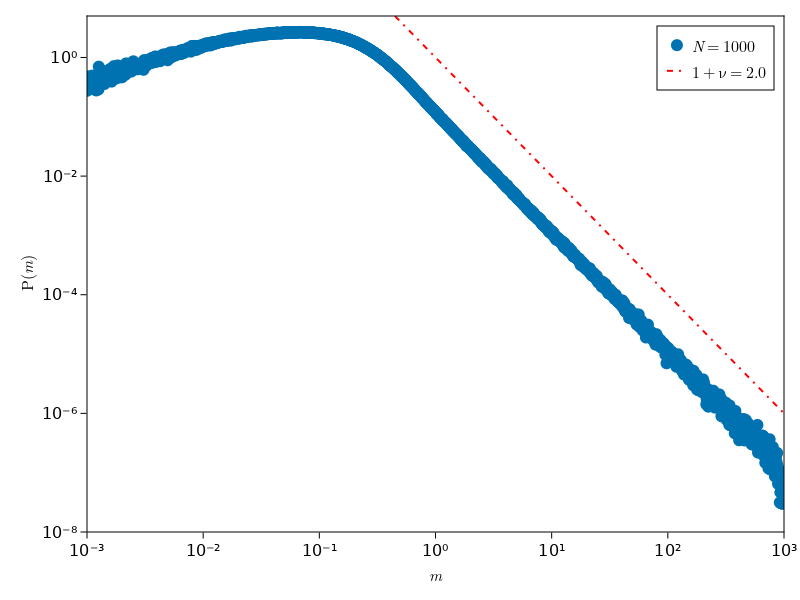

In [5]:
fig::Figure = Figure()
ax::Axis = Axis(
    fig[1, 1],
    xscale=log10,
    yscale=log10,
    xlabel=L"m",
    ylabel=L"\mathrm{P}(m)",
)
S01 = scatter!(
    ax, eachcol(replace(result1000, 0.0 => NaN))...;
    markersize=12
)
L = lines!(
    ax, result1000[:, 1], result1000[:, 1] .^ (-2);
    color=:red, linestyle=:dashdot, linewidth=2)

xlims!(ax, 1e-3, 1e3)
ylims!(ax, 1e-8, 5e0)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
axislegend(ax, [S01, L], [L"N=1000", L"1+\nu = 2.0"])
fig

In [6]:
# save("/tmp/t.svg",fig)

### import data about lambda

In [7]:
path_2_lambda200 = "../data/N200/lambda/"
path_2_m200 = "../data/N200/m/"
lambda_file_name200::Array{String} = readdir(path_2_lambda200)# use readdir function to get all filename in the parent directory (path_2_m)
m_file_name200::Array{String} = readdir(path_2_m200)# use readdir function to get all filename in the parent directory (path_2_m)
lambda_all200::Matrix{Float64} = vcat([Matrix(CSV.read(path_2_lambda200 * mfn, DataFrame)) for mfn in lambda_file_name200]...)
m_all200::Matrix{Float64} = vcat([Matrix(CSV.read(path_2_m200 * mfn, DataFrame)) for mfn in m_file_name200]...);

In [8]:
path_2_lambda100 = "../data/N100/lambda/";
path_2_m100 = "../data/N100/m/";
lambda_file_name100::Array{String} = readdir(path_2_lambda100);# use readdir function to get all filename in the parent directory (path_2_m)
m_file_name100::Array{String} = readdir(path_2_m100);# use readdir function to get all filename in the parent directory (path_2_m)
lambda_all100::Matrix{Float64} = vcat([Matrix(CSV.read(path_2_lambda100 * mfn, DataFrame)) for mfn in lambda_file_name100]...);
m_all100::Matrix{Float64} = vcat([Matrix(CSV.read(path_2_m100 * mfn, DataFrame)) for mfn in m_file_name100]...);

In [9]:
r06 = m2pd(m_all200[findall(x -> 0.59 <= x <= 0.61, lambda_all200)], ps=[0:0.03:3...]);
r08 = m2pd(m_all200[findall(x -> 0.79 <= x <= 0.81, lambda_all200)], ps=[0:0.05:3...]);
r09 = m2pd(m_all200[findall(x -> 0.89 <= x <= 0.91, lambda_all200)], ps=[0:0.07:3...]);

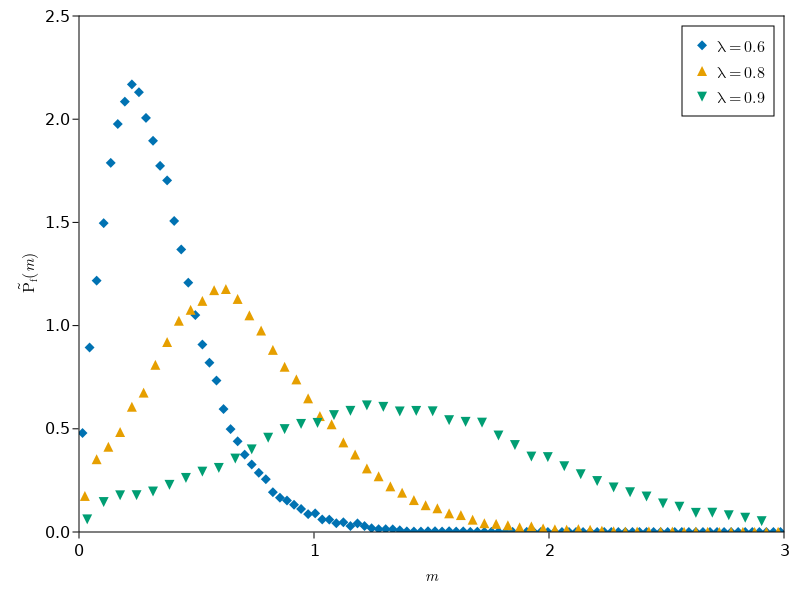

In [10]:
fig2 = Figure()
ax2 = Axis(
    fig2[1, 1],
    xlabel=L"m",
    ylabel=L"\mathrm{\tilde{P}_{f}}(m)"
)
s01 = scatter!(ax2, r06[:, 1], r06[:, 2], marker=:diamond, markersize=13)
s02 = scatter!(ax2, r08[:, 1], r08[:, 2], marker=:utriangle, markersize=13)
s03 = scatter!(ax2, r09[:, 1], r09[:, 2], marker=:dtriangle, markersize=13)
hidedecorations!(ax2, ticks=false, ticklabels=false, label=false)
axislegend(ax2, [s01, s02, s03], [L"\lambda=0.6", L"\lambda=0.8", L"\lambda=0.9"])
xlims!(ax2, 0, 3)
ylims!(ax2, 0, 2.5)
fig2

In [11]:
# save("/tmp/t.svg",fig2)

## Import data from N100
> This section describe the distribution of the wealth when the $\lambda$ is not uniform

In [12]:
path2N100 = "../data/N100/";

In [13]:
reg_alpha = r"^alpha*";
reg_u = r"^u[0-9]{2}";
dirnamealpha = readdir(path2N100);
path2N100_alpha_subdir = filter(x -> !isnothing(x), [occursin(reg_alpha, dn) ? dn : nothing for dn in dirnamealpha]);
path2N100_u_subdir = filter(x -> !isnothing(x), [occursin(reg_u, dn) ? dn : nothing for dn in dirnamealpha]);
path2N100_subdir = vcat(path2N100_u_subdir, path2N100_alpha_subdir);

In [14]:
lambda_filename_dict = Dict()
m_filename_dict = Dict()
lambda_N100 = Dict()
m_N100 = Dict()
reglambda = r"^lambda.*.csv"
regm = r"^m.*.csv"

for p2s in path2N100_subdir
    lambda_filename_dict[Symbol(p2s)] = filter(x -> !isnothing(x), [occursin(reglambda, fnl) ? joinpath(p2s, fnl) : nothing for fnl in readdir(joinpath(path2N100, p2s))])
    m_filename_dict[Symbol(p2s)] = filter(x -> !isnothing(x), [occursin(regm, fnl) ? joinpath(p2s, fnl) : nothing for fnl in readdir(joinpath(path2N100, p2s))])
end

for p2s in path2N100_subdir
    lambda_N100[Symbol(p2s)] = vcat([Matrix(CSV.read(joinpath(path2N100, i), DataFrame, header=false)) for i in lambda_filename_dict[Symbol(p2s)]]...)
    m_N100[Symbol(p2s)] = vcat([Matrix(CSV.read(joinpath(path2N100, i), DataFrame, header=false)) for i in m_filename_dict[Symbol(p2s)]]...)
end

- the distribution of $\lambda$

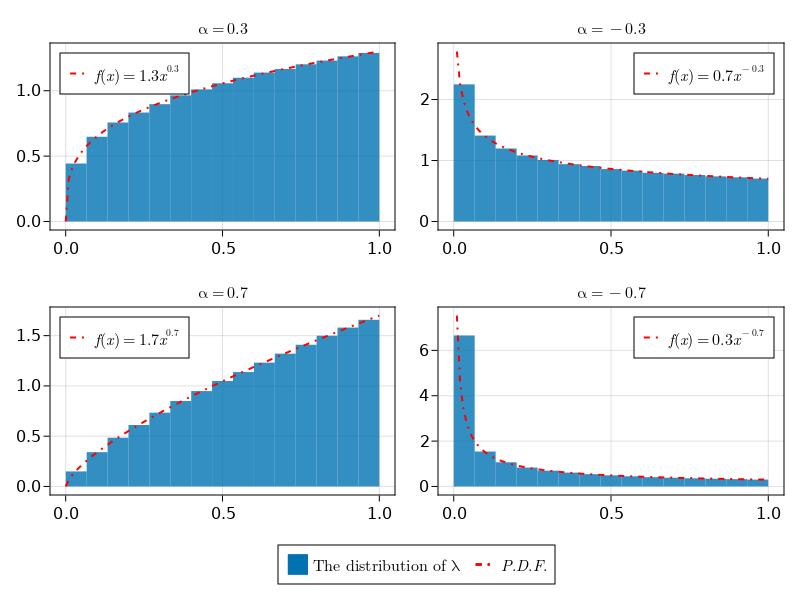

In [15]:
x = [0:0.01:1...]
fig3 = Figure()
axN1001 = Axis(fig3[1, 1], title=L"\alpha=0.3")
axN1002 = Axis(fig3[1, 2], title=L"\alpha=-0.3")
axN1003 = Axis(fig3[2, 1], title=L"\alpha=0.7")
axN1004 = Axis(fig3[2, 2], title=L"\alpha=-0.7")

h1 = hist!(axN1001, vec(reshape(lambda_N100[:alpha03], 10000 * 100, 1)), normalization=:pdf)
l1 = lines!(axN1001, x, 1.3 * x .^ (0.3), color=:red, linestyle=:dashdot, linewidth=2)
axislegend(axN1001, [l1], [L"f(x) = 1.3 x^{0.3}"], position=:lt)

h2 = hist!(axN1002, vec(reshape(lambda_N100[:alphan03], 10000 * 100, 1)), normalization=:pdf)
l2 = lines!(axN1002, x, 0.7 * x .^ (-0.3), color=:red, linestyle=:dashdot, linewidth=2)
axislegend(axN1002, [l2], [L"f(x) = 0.7 x^{-0.3}"], position=:rt)

h3 = hist!(axN1003, vec(reshape(lambda_N100[:alpha07], 10000 * 100, 1)), normalization=:pdf)
l3 = lines!(axN1003, x, 1.7 * x .^ (0.7), color=:red, linestyle=:dashdot, linewidth=2)
axislegend(axN1003, [l3], [L"f(x) = 1.7 x^{0.7}"], position=:lt)

h4 = hist!(axN1004, vec(reshape(lambda_N100[:alphan07], 10000 * 100, 1)), normalization=:pdf)
l4 = lines!(axN1004, x, 0.3 * x .^ (-0.7), color=:red, linestyle=:dashdot, linewidth=2)
axislegend(axN1004, [l4], [L"f(x) = 0.3 x^{-0.7}"], position=:rt)

Legend(fig3[3, :], [[h1, h2, h3, h4], [l1, l2, l3, l4]], [L"The distribution of $\lambda$", L"P.D.F."], tellheight=true, orientation=:horizontal)
fig3

In [16]:
# save("/tmp/t.svg",fig3)

In [17]:
ps = 10 .^ (-2:0.005:2);
result100an03 = m2pd_all(m_N100[:alphan03], ps=ps);
result100a03 = m2pd_all(m_N100[:alpha03], ps=ps);
result100an07 = m2pd_all(m_N100[:alphan07], ps=ps);
result100a07 = m2pd_all(m_N100[:alpha07], ps=ps);

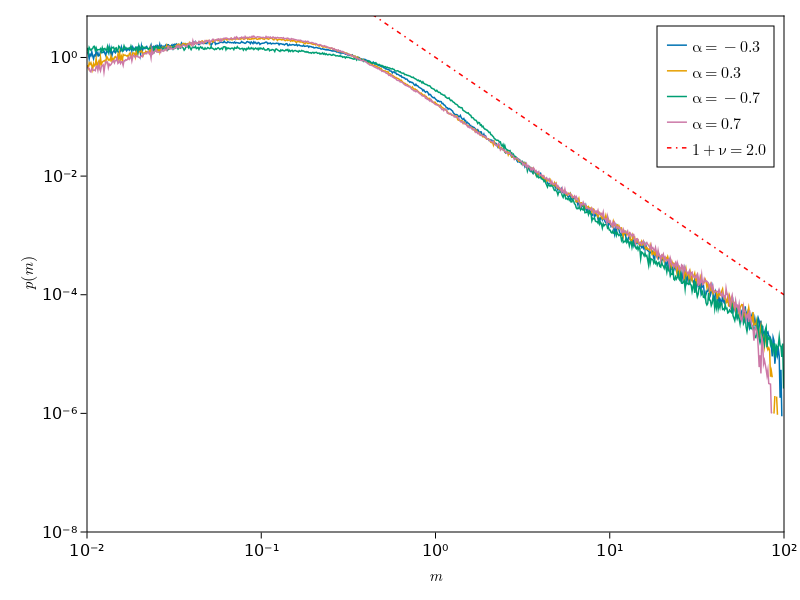

In [18]:
fig4::Figure = Figure()
ax41::Axis = Axis(
    fig4[1, 1],
    xscale=log10,
    yscale=log10,
    xlabel=L"m",
    ylabel=L"p(m)",
)

l41 = lines!(ax41, eachcol(replace(result100an03, 0.0 => NaN))...;)
l42 = lines!(ax41, eachcol(replace(result100a03, 0.0 => NaN))...;)
l43 = lines!(ax41, eachcol(replace(result100an07, 0.0 => NaN))...;)
l44 = lines!(ax41, eachcol(replace(result100a07, 0.0 => NaN))...)
l45 = lines!(ax41, [1e-2:1e-2:1e2...], [1e-2:1e-2:1e2...] .^ (-2), color=:red, linestyle=:dashdot)

xlims!(ax41, 1e-2, 1e2)
ylims!(ax41, 1e-8, 5e0)
hidedecorations!(ax41, ticks=false, ticklabels=false, label=false)
axislegend(ax41, [l41, l42, l43, l44, l45], [L"\alpha=-0.3", L"\alpha=0.3", L"\alpha=-0.7", L"\alpha=0.7", L"1+\nu = 2.0"])
fig4

In [19]:
# save("/tmp/t.svg",fig4)

In [20]:
ps2 = 10 .^ (-2:0.0025:2);
result100u51 = m2pd_all(m_N100[:u51], ps=ps2);
result100u05 = m2pd_all(m_N100[:u05], ps=ps2);
result100u79 = m2pd_all(m_N100[:u79], ps=ps2);
result100u24 = m2pd_all(m_N100[:u24], ps=ps2);
result100u81 = m2pd_all(m_N100[:u81], ps=ps2);

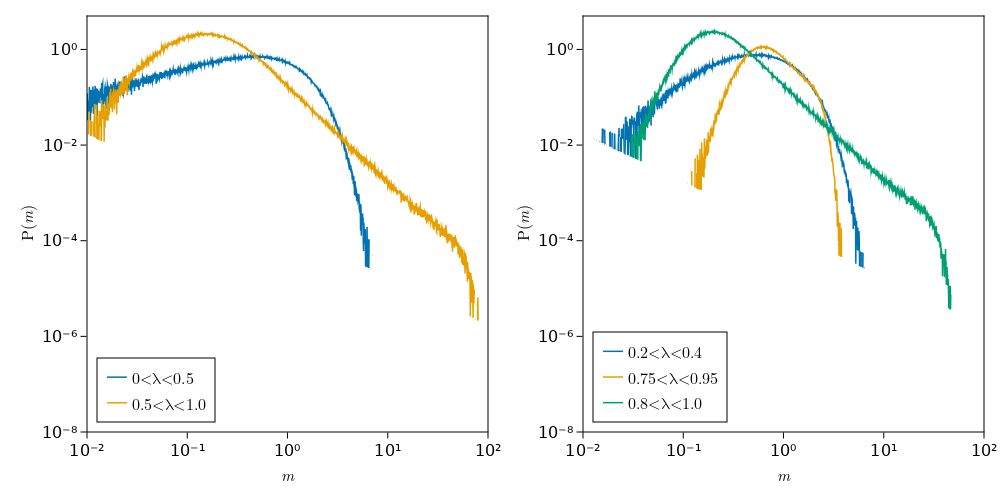

In [21]:
fig5::Figure = Figure(resolution=(1000, 500))
ax51::Axis = Axis(
    fig5[1, 1],
    xscale=log10,
    yscale=log10,
    xlabel=L"m",
    ylabel=L"\mathrm{P}(m)",
)
ax52::Axis = Axis(
    fig5[1, 2],
    xscale=log10,
    yscale=log10,
    xlabel=L"m",
    ylabel=L"\mathrm{P}(m)",
)

l51 = lines!(ax51, eachcol(replace(result100u05, 0.0 => NaN))...;)
l52 = lines!(ax51, eachcol(replace(result100u51, 0.0 => NaN))...;)
l53 = lines!(ax52, eachcol(replace(result100u24, 0.0 => NaN))...;)
l54 = lines!(ax52, eachcol(replace(result100u79, 0.0 => NaN))...;)
l55 = lines!(ax52, eachcol(replace(result100u81, 0.0 => NaN))...;)

xlims!(ax51, 1e-2, 1e2)
ylims!(ax51, 1e-8, 5e0)
xlims!(ax52, 1e-2, 1e2)
ylims!(ax52, 1e-8, 5e0)
axislegend(ax51, [l51, l52], [L"0<\lambda<0.5", L"0.5<\lambda<1.0"], position=:lb)
axislegend(ax52, [l53, l54, l55], [L"0.2<\lambda<0.4", L"0.75<\lambda<0.95", L"0.8<\lambda<1.0"], position=:lb)
hidedecorations!(ax51, ticks=false, ticklabels=false, label=false)
hidedecorations!(ax52, ticks=false, ticklabels=false, label=false)
fig5

In [22]:
# save("/tmp/t.svg", fig5);